In [ ]:
!pip install albumentations
!pip install torchsummary
!pip install segmentation_models_pytorch
# !pip install --upgrade opencv-python

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
  Obtaining dependency information for albumentations from https://files.pythonhosted.org/packages/9b/f6/c486cedb4f75147232f32ec4c97026714cfef7c7e247a1f0427bc5489f66/albumentations-1.3.1-py3-none-any.whl.metadata
  Obtaining dependency information for scikit-image>=0.16.1 from https://files.pythonhosted.org/packages/f1/6c/49f5a0ce8ddcdbdac5ac69c129654938cc6de0a936303caa6cad495ceb2a/scikit_image-0.22.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
  Obtaining dependency information for opencv-python-headless>=4.1.1 from https://files.pythonhosted.org/packages/9d/d7/e2aaf344254292d2046f9984b54212e4e7d69a57d30ae15e7294840710f6/opencv_python_headless-4.8.1.78-cp37-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
  Obtaining dependency information for networkx>=2.8 from https://files.pythonhosted.org/packages/d5/f0/8fbc882ca80cf077f1b246c0e3c3465f7f415439bdea6b899f6b19f61f70/networkx-3

In [ ]:
# import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
import torchvision
import torch.nn.functional as F
from torch.autograd import Variable

from PIL import Image
import albumentations as A

import time
import os
from tqdm import tqdm

from torchsummary import summary
import segmentation_models_pytorch as smp
from utils import rgb2mask

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
IMAGE_PATH = 'Data/images/'
MASK_PATH = 'Data/masks/'

In [ ]:
n_classes = 4

def create_df():
    name = []
    for dirname, _, filenames in os.walk(IMAGE_PATH):
        for filename in filenames:
            name.append(filename.split('.')[0])

    return pd.DataFrame({'id': name}, index = np.arange(0, len(name)))

df = create_df()
print('Total Images: ', len(df))

Total Images:  1339


In [ ]:
#split data
X_trainval, X_test = train_test_split(df['id'].values, test_size=0.1, random_state=123)
X_train, X_val = train_test_split(X_trainval, test_size=0.1, random_state=123)

print('Train Size   : ', len(X_train))
print('Val Size     : ', len(X_val))
print('Test Size    : ', len(X_test))

Train Size   :  1084
Val Size     :  121
Test Size    :  134


Image Size (2048, 2048)
Mask Size (2048, 2048, 3)


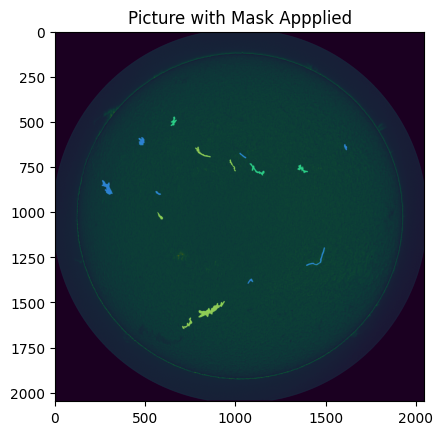

In [ ]:
#Plotting mask overlayed on image
img = Image.open(IMAGE_PATH + df['id'][100] + '.jpeg')
mask = Image.open(MASK_PATH + df['id'][100] + '.png')
print('Image Size', np.asarray(img).shape)
print('Mask Size', np.asarray(mask).shape)


plt.imshow(img)
plt.imshow(mask, alpha=0.6)
plt.title('Picture with Mask Appplied')
plt.show()

In [ ]:
#Data Loader
class FilamentDataset(Dataset):

    def __init__(self, img_path, mask_path, X, mean, std, transform=None, patch=False):
        self.img_path = img_path
        self.mask_path = mask_path
        self.X = X
        self.transform = transform
        self.patches = patch
        self.mean = mean
        self.std = std

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        img = cv2.imread(self.img_path + self.X[idx] + '.jpeg', cv2.IMREAD_GRAYSCALE)
        # img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.mask_path + self.X[idx] + '.png')
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)

        # Convert the mask from RGB to 2D grayscale
        mask = rgb2mask(mask)

        if self.transform is not None:
            aug = self.transform(image=img, mask=mask)
            img = Image.fromarray(aug['image'])
            mask = aug['mask']

        if self.transform is None:
            img = Image.fromarray(img)

        # Convert the PIL image to a NumPy array to calculate mean and std
        img_array = np.array(img)
        # Calculate the mean and standard deviation for normalization
        img_mean = img_array.mean(axis=(0, 1)) / 255.0  # Normalize to [0, 1]
        img_std = img_array.std(axis=(0, 1)) / 255.0

        t = T.Compose([T.ToTensor(), T.Normalize(img_mean.tolist(), img_std.tolist())])
        img = t(img)
        mask = torch.from_numpy(mask).long()

        if self.patches:
            img, mask = self.tiles(img, mask)

        return img, mask

    def tiles(self, img, mask):

        img_patches = img.unfold(0, 512, 512).unfold(1, 512, 512)
        img_patches = img_patches.contiguous().view(-1, 512, 512)

        mask_patches = mask.unfold(0, 512, 512).unfold(1, 512, 512)
        mask_patches = mask_patches.contiguous().view(-1, 512, 512)

        return img_patches, mask_patches

In [ ]:
#Data Normalize

mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]

# t_train = A.Compose([A.Resize(704, 1056, interpolation=cv2.INTER_NEAREST), A.HorizontalFlip(), A.VerticalFlip(),
#                      A.GridDistortion(p=0.2), A.RandomBrightnessContrast((0,0.5),(0,0.5)),
#                      A.GaussNoise()])

# t_val = A.Compose([A.Resize(704, 1056, interpolation=cv2.INTER_NEAREST), A.HorizontalFlip(),
#                    A.GridDistortion(p=0.2)])

t_train = None
t_val = None

#datasets
train_set = FilamentDataset(IMAGE_PATH, MASK_PATH, X_train, mean, std, t_train, patch=False)
val_set = FilamentDataset(IMAGE_PATH, MASK_PATH, X_val, mean, std, t_val, patch=False)

#dataloader
batch_size= 4

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=True)

In [ ]:
#Checking Data Loader

import matplotlib.pyplot as plt
import numpy as np

# Get some random training images
dataiter = iter(train_loader)
images, masks = next(dataiter)

# Display images and masks along with their sizes
fig, axes = plt.subplots(2, batch_size, figsize=(20, 8))

for i in range(batch_size):
    # Display an image
    img = images[i][0]
    img_size = img.shape
    axes[0, i].imshow(img, cmap='gray')
    axes[0, i].set_title(f'Image - Size: {img_size}')

    # Display the corresponding mask
    mask = masks[i]
    mask_size = mask.shape
    axes[1, i].imshow(mask, cmap='gray')
    axes[1, i].set_title(f'Mask - Size: {mask_size}')

plt.show()


In [ ]:
#Loading Model
model = smp.Unet('mobilenet_v2', encoder_weights='imagenet', classes=4, activation=None, encoder_depth=5, decoder_channels=[256, 128, 64, 32, 16], in_channels=1)

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13.6M/13.6M [00:00<00:00, 84.1MB/s]


In [ ]:
model

Unet(
  (encoder): MobileNetV2Encoder(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (1): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU6(inplace=True)
          )
          (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (2): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 96, kernel_size=(1

Training

In [ ]:
#pixel Loss
def pixel_accuracy(output, mask):
    with torch.no_grad():
        output = torch.argmax(F.softmax(output, dim=1), dim=1)
        correct = torch.eq(output, mask).int()
        accuracy = float(correct.sum()) / float(correct.numel())
    return accuracy

In [ ]:
#Miou Loss
def mIoU(pred_mask, mask, smooth=1e-10, n_classes=4):
    with torch.no_grad():
        pred_mask = F.softmax(pred_mask, dim=1)
        pred_mask = torch.argmax(pred_mask, dim=1)
        pred_mask = pred_mask.contiguous().view(-1)
        mask = mask.contiguous().view(-1)

        iou_per_class = []
        for clas in range(0, n_classes): #loop per pixel class
            true_class = pred_mask == clas
            true_label = mask == clas

            if true_label.long().sum().item() == 0: #no exist label in this loop
                iou_per_class.append(np.nan)
            else:
                intersect = torch.logical_and(true_class, true_label).sum().float().item()
                union = torch.logical_or(true_class, true_label).sum().float().item()

                iou = (intersect + smooth) / (union +smooth)
                iou_per_class.append(iou)
        return np.nanmean(iou_per_class)

In [ ]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

In [ ]:
#Training Loop
def fit(epochs, model, train_loader, val_loader, optimizer, scheduler, patch=False):
    torch.cuda.empty_cache()
    train_losses = []
    test_losses = []
    val_iou = []; val_acc = []
    train_iou = []; train_acc = []
    lrs = []
    min_loss = np.inf
    decrease = 1 ; not_improve=0

    model.to(device)
    fit_time = time.time()
    for e in range(epochs):
        since = time.time()
        running_loss = 0
        iou_score = 0
        accuracy = 0
        #training loop
        model.train()
        for i, data in enumerate(tqdm(train_loader)):
            #training phase
            image_tiles, mask_tiles = data
            if patch:
                bs, n_tiles, c, h, w = image_tiles.size()

                image_tiles = image_tiles.view(-1,c, h, w)
                mask_tiles = mask_tiles.view(-1, h, w)

            image = image_tiles.to(device); mask = mask_tiles.to(device);
            #forward
            output = model(image)
            loss = criterion.forward(output, mask)
            #evaluation metrics
            iou_score += mIoU(output, mask)
            accuracy += pixel_accuracy(output, mask)
            #backward
            loss.backward()
            optimizer.step() #update weight
            optimizer.zero_grad() #reset gradient

            #step the learning rate
            lrs.append(get_lr(optimizer))
            scheduler.step()

            running_loss += loss.item()

        else:
            model.eval()
            test_loss = 0
            test_accuracy = 0
            val_iou_score = 0
            #validation loop
            with torch.no_grad():
                for i, data in enumerate(tqdm(val_loader)):
                    #reshape to 9 patches from single image, delete batch size
                    image_tiles, mask_tiles = data

                    if patch:
                        bs, n_tiles, c, h, w = image_tiles.size()

                        image_tiles = image_tiles.view(-1,c, h, w)
                        mask_tiles = mask_tiles.view(-1, h, w)

                    image = image_tiles.to(device); mask = mask_tiles.to(device);
                    output = model(image)
                    #evaluation metrics
                    val_iou_score +=  mIoU(output, mask)
                    test_accuracy += pixel_accuracy(output, mask)
                    #loss
                    loss = criterion.forward(output, mask)
                    test_loss += loss.item()

            #calculatio mean for each batch
            train_losses.append(running_loss/len(train_loader))
            test_losses.append(test_loss/len(val_loader))


            print('Loss Decreasing.. {:.3f} >> {:.3f} '.format(min_loss, (test_loss/len(val_loader))))
            min_loss = (test_loss/len(val_loader))
            if e%10 == 0:
                print('saving model...')
                torch.save(model, f'IOU_Unet-Mobilenet_v2_mIoU_{e}_epochs.pt')

            #iou
            val_iou.append(val_iou_score/len(val_loader))
            train_iou.append(iou_score/len(train_loader))
            train_acc.append(accuracy/len(train_loader))
            val_acc.append(test_accuracy/ len(val_loader))
            print("Epoch:{}/{}..".format(e+1, epochs),
                  "Train Loss: {:.3f}..".format(running_loss/len(train_loader)),
                  "Val Loss: {:.3f}..".format(test_loss/len(val_loader)),
                  "Train mIoU:{:.3f}..".format(iou_score/len(train_loader)),
                  "Val mIoU: {:.3f}..".format(val_iou_score/len(val_loader)),
                  "Train Acc:{:.3f}..".format(accuracy/len(train_loader)),
                  "Val Acc:{:.3f}..".format(test_accuracy/len(val_loader)),
                  "Time: {:.2f}m".format((time.time()-since)/60))

    history = {'train_loss' : train_losses, 'val_loss': test_losses,
               'train_miou' :train_iou, 'val_miou':val_iou,
               'train_acc' :train_acc, 'val_acc':val_acc,
               'lrs': lrs}
    print('Total time: {:.2f} m' .format((time.time()- fit_time)/60))
    return history

In [ ]:
max_lr = 1e-3
epoch = 50
weight_decay = 1e-4

criterion = smp.losses.JaccardLoss('multiclass', from_logits=True)
optimizer = torch.optim.AdamW(model.parameters(), lr=max_lr, weight_decay=weight_decay)
sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epoch,
                                            steps_per_epoch=len(train_loader))

history = fit(epoch, model, train_loader, val_loader, optimizer, sched)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [01:33<00:00,  3.03s/it]


Loss Decreasing.. inf >> 0.771 
saving model...
Epoch:1/50.. Train Loss: 0.830.. Val Loss: 0.771.. Train mIoU:0.233.. Val mIoU: 0.287.. Train Acc:0.895.. Val Acc:0.988.. Time: 18.46m


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [01:33<00:00,  3.01s/it]


Loss Decreasing.. 0.771 >> 0.727 
Epoch:2/50.. Train Loss: 0.762.. Val Loss: 0.727.. Train mIoU:0.312.. Val mIoU: 0.326.. Train Acc:0.990.. Val Acc:0.994.. Time: 18.45m


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [01:33<00:00,  3.02s/it]


Loss Decreasing.. 0.727 >> 0.653 
Epoch:3/50.. Train Loss: 0.697.. Val Loss: 0.653.. Train mIoU:0.356.. Val mIoU: 0.355.. Train Acc:0.995.. Val Acc:0.996.. Time: 18.38m


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [01:34<00:00,  3.03s/it]


Loss Decreasing.. 0.653 >> 0.621 
Epoch:4/50.. Train Loss: 0.624.. Val Loss: 0.621.. Train mIoU:0.385.. Val mIoU: 0.383.. Train Acc:0.997.. Val Acc:0.997.. Time: 18.45m


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [01:33<00:00,  3.03s/it]


Loss Decreasing.. 0.621 >> 0.597 
Epoch:5/50.. Train Loss: 0.597.. Val Loss: 0.597.. Train mIoU:0.408.. Val mIoU: 0.397.. Train Acc:0.996.. Val Acc:0.996.. Time: 18.38m


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [01:33<00:00,  3.01s/it]


Loss Decreasing.. 0.597 >> 0.686 
Epoch:6/50.. Train Loss: 0.600.. Val Loss: 0.686.. Train mIoU:0.402.. Val mIoU: 0.314.. Train Acc:0.996.. Val Acc:0.996.. Time: 18.30m


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [01:33<00:00,  3.01s/it]


Loss Decreasing.. 0.686 >> 0.613 
Epoch:7/50.. Train Loss: 0.592.. Val Loss: 0.613.. Train mIoU:0.409.. Val mIoU: 0.383.. Train Acc:0.996.. Val Acc:0.997.. Time: 18.25m


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [01:33<00:00,  3.00s/it]


Loss Decreasing.. 0.613 >> 0.626 
Epoch:8/50.. Train Loss: 0.584.. Val Loss: 0.626.. Train mIoU:0.416.. Val mIoU: 0.375.. Train Acc:0.997.. Val Acc:0.995.. Time: 18.29m


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [01:32<00:00,  3.00s/it]


Loss Decreasing.. 0.626 >> 0.606 
Epoch:9/50.. Train Loss: 0.580.. Val Loss: 0.606.. Train mIoU:0.419.. Val mIoU: 0.389.. Train Acc:0.996.. Val Acc:0.997.. Time: 18.29m


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [01:32<00:00,  3.00s/it]


Loss Decreasing.. 0.606 >> 0.621 
Epoch:10/50.. Train Loss: 0.588.. Val Loss: 0.621.. Train mIoU:0.412.. Val mIoU: 0.379.. Train Acc:0.996.. Val Acc:0.996.. Time: 18.20m


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [01:38<00:00,  3.19s/it]


Loss Decreasing.. 0.621 >> 0.645 
saving model...
Epoch:11/50.. Train Loss: 0.614.. Val Loss: 0.645.. Train mIoU:0.386.. Val mIoU: 0.350.. Train Acc:0.996.. Val Acc:0.995.. Time: 18.83m


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [01:38<00:00,  3.18s/it]


Loss Decreasing.. 0.645 >> 0.630 
Epoch:12/50.. Train Loss: 0.587.. Val Loss: 0.630.. Train mIoU:0.413.. Val mIoU: 0.371.. Train Acc:0.996.. Val Acc:0.996.. Time: 19.09m


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [01:39<00:00,  3.20s/it]


Loss Decreasing.. 0.630 >> 0.586 
Epoch:13/50.. Train Loss: 0.587.. Val Loss: 0.586.. Train mIoU:0.412.. Val mIoU: 0.401.. Train Acc:0.997.. Val Acc:0.997.. Time: 19.11m


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [01:38<00:00,  3.19s/it]


Loss Decreasing.. 0.586 >> 0.612 
Epoch:14/50.. Train Loss: 0.587.. Val Loss: 0.612.. Train mIoU:0.413.. Val mIoU: 0.388.. Train Acc:0.997.. Val Acc:0.996.. Time: 19.16m


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [01:39<00:00,  3.20s/it]


Loss Decreasing.. 0.612 >> 0.602 
Epoch:15/50.. Train Loss: 0.577.. Val Loss: 0.602.. Train mIoU:0.422.. Val mIoU: 0.394.. Train Acc:0.997.. Val Acc:0.996.. Time: 19.13m


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [01:38<00:00,  3.18s/it]


Loss Decreasing.. 0.602 >> 0.593 
Epoch:16/50.. Train Loss: 0.579.. Val Loss: 0.593.. Train mIoU:0.420.. Val mIoU: 0.402.. Train Acc:0.997.. Val Acc:0.996.. Time: 19.16m


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [01:32<00:00,  3.00s/it]


Loss Decreasing.. 0.593 >> 0.607 
Epoch:17/50.. Train Loss: 0.591.. Val Loss: 0.607.. Train mIoU:0.409.. Val mIoU: 0.385.. Train Acc:0.996.. Val Acc:0.997.. Time: 18.73m


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [01:33<00:00,  3.01s/it]


Loss Decreasing.. 0.607 >> 0.593 
Epoch:18/50.. Train Loss: 0.582.. Val Loss: 0.593.. Train mIoU:0.418.. Val mIoU: 0.397.. Train Acc:0.997.. Val Acc:0.996.. Time: 18.36m


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [01:38<00:00,  3.18s/it]


Loss Decreasing.. 0.593 >> 0.653 
Epoch:19/50.. Train Loss: 0.580.. Val Loss: 0.653.. Train mIoU:0.419.. Val mIoU: 0.349.. Train Acc:0.997.. Val Acc:0.993.. Time: 19.23m


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [01:39<00:00,  3.20s/it]


Loss Decreasing.. 0.653 >> 0.599 
Epoch:20/50.. Train Loss: 0.587.. Val Loss: 0.599.. Train mIoU:0.413.. Val mIoU: 0.396.. Train Acc:0.997.. Val Acc:0.996.. Time: 19.27m


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [01:38<00:00,  3.19s/it]


Loss Decreasing.. 0.599 >> 0.594 
saving model...
Epoch:21/50.. Train Loss: 0.569.. Val Loss: 0.594.. Train mIoU:0.431.. Val mIoU: 0.401.. Train Acc:0.997.. Val Acc:0.997.. Time: 19.22m


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [01:37<00:00,  3.13s/it]


Loss Decreasing.. 0.594 >> 0.595 
Epoch:22/50.. Train Loss: 0.573.. Val Loss: 0.595.. Train mIoU:0.427.. Val mIoU: 0.405.. Train Acc:0.997.. Val Acc:0.997.. Time: 19.17m


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [01:38<00:00,  3.17s/it]


Loss Decreasing.. 0.595 >> 0.590 
Epoch:23/50.. Train Loss: 0.574.. Val Loss: 0.590.. Train mIoU:0.424.. Val mIoU: 0.400.. Train Acc:0.997.. Val Acc:0.996.. Time: 19.10m


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [01:39<00:00,  3.20s/it]


Loss Decreasing.. 0.590 >> 0.593 
Epoch:24/50.. Train Loss: 0.564.. Val Loss: 0.593.. Train mIoU:0.434.. Val mIoU: 0.407.. Train Acc:0.997.. Val Acc:0.996.. Time: 19.12m


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [01:33<00:00,  3.03s/it]


Loss Decreasing.. 0.593 >> 0.573 
Epoch:25/50.. Train Loss: 0.564.. Val Loss: 0.573.. Train mIoU:0.435.. Val mIoU: 0.423.. Train Acc:0.997.. Val Acc:0.996.. Time: 18.62m


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [01:34<00:00,  3.03s/it]


Loss Decreasing.. 0.573 >> 0.590 
Epoch:26/50.. Train Loss: 0.552.. Val Loss: 0.590.. Train mIoU:0.447.. Val mIoU: 0.410.. Train Acc:0.997.. Val Acc:0.996.. Time: 18.35m


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [01:34<00:00,  3.04s/it]


Loss Decreasing.. 0.590 >> 0.568 
Epoch:27/50.. Train Loss: 0.551.. Val Loss: 0.568.. Train mIoU:0.449.. Val mIoU: 0.427.. Train Acc:0.997.. Val Acc:0.997.. Time: 18.35m


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [01:34<00:00,  3.04s/it]


Loss Decreasing.. 0.568 >> 0.580 
Epoch:28/50.. Train Loss: 0.549.. Val Loss: 0.580.. Train mIoU:0.451.. Val mIoU: 0.420.. Train Acc:0.997.. Val Acc:0.997.. Time: 18.38m


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [01:34<00:00,  3.03s/it]


Loss Decreasing.. 0.580 >> 0.580 
Epoch:29/50.. Train Loss: 0.539.. Val Loss: 0.580.. Train mIoU:0.460.. Val mIoU: 0.417.. Train Acc:0.997.. Val Acc:0.997.. Time: 18.38m


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [01:34<00:00,  3.06s/it]


Loss Decreasing.. 0.580 >> 0.565 
Epoch:30/50.. Train Loss: 0.538.. Val Loss: 0.565.. Train mIoU:0.462.. Val mIoU: 0.431.. Train Acc:0.997.. Val Acc:0.997.. Time: 18.44m


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [01:34<00:00,  3.04s/it]


Loss Decreasing.. 0.565 >> 0.592 
saving model...
Epoch:31/50.. Train Loss: 0.530.. Val Loss: 0.592.. Train mIoU:0.469.. Val mIoU: 0.408.. Train Acc:0.997.. Val Acc:0.997.. Time: 18.41m


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [01:34<00:00,  3.04s/it]


Loss Decreasing.. 0.592 >> 0.567 
Epoch:32/50.. Train Loss: 0.531.. Val Loss: 0.567.. Train mIoU:0.469.. Val mIoU: 0.425.. Train Acc:0.997.. Val Acc:0.997.. Time: 18.37m


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [01:34<00:00,  3.04s/it]


Loss Decreasing.. 0.567 >> 0.578 
Epoch:33/50.. Train Loss: 0.527.. Val Loss: 0.578.. Train mIoU:0.472.. Val mIoU: 0.422.. Train Acc:0.997.. Val Acc:0.997.. Time: 18.37m


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [01:34<00:00,  3.05s/it]


Loss Decreasing.. 0.578 >> 0.576 
Epoch:34/50.. Train Loss: 0.517.. Val Loss: 0.576.. Train mIoU:0.482.. Val mIoU: 0.418.. Train Acc:0.997.. Val Acc:0.997.. Time: 18.43m


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [01:33<00:00,  3.03s/it]


Loss Decreasing.. 0.576 >> 0.575 
Epoch:35/50.. Train Loss: 0.510.. Val Loss: 0.575.. Train mIoU:0.489.. Val mIoU: 0.426.. Train Acc:0.997.. Val Acc:0.997.. Time: 18.38m


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [01:33<00:00,  3.01s/it]


Loss Decreasing.. 0.575 >> 0.567 
Epoch:36/50.. Train Loss: 0.505.. Val Loss: 0.567.. Train mIoU:0.494.. Val mIoU: 0.428.. Train Acc:0.997.. Val Acc:0.997.. Time: 18.23m


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [01:33<00:00,  3.00s/it]


Loss Decreasing.. 0.567 >> 0.553 
Epoch:37/50.. Train Loss: 0.502.. Val Loss: 0.553.. Train mIoU:0.498.. Val mIoU: 0.441.. Train Acc:0.997.. Val Acc:0.997.. Time: 18.23m


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [01:33<00:00,  3.01s/it]


Loss Decreasing.. 0.553 >> 0.570 
Epoch:38/50.. Train Loss: 0.492.. Val Loss: 0.570.. Train mIoU:0.507.. Val mIoU: 0.430.. Train Acc:0.997.. Val Acc:0.997.. Time: 18.26m


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [01:33<00:00,  3.00s/it]


Loss Decreasing.. 0.570 >> 0.566 
Epoch:39/50.. Train Loss: 0.491.. Val Loss: 0.566.. Train mIoU:0.508.. Val mIoU: 0.429.. Train Acc:0.997.. Val Acc:0.997.. Time: 18.26m


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [01:32<00:00,  2.97s/it]


Loss Decreasing.. 0.566 >> 0.584 
Epoch:40/50.. Train Loss: 0.489.. Val Loss: 0.584.. Train mIoU:0.510.. Val mIoU: 0.416.. Train Acc:0.997.. Val Acc:0.997.. Time: 18.23m


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [01:31<00:00,  2.97s/it]


Loss Decreasing.. 0.584 >> 0.565 
saving model...
Epoch:41/50.. Train Loss: 0.481.. Val Loss: 0.565.. Train mIoU:0.518.. Val mIoU: 0.427.. Train Acc:0.997.. Val Acc:0.997.. Time: 18.16m


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [01:31<00:00,  2.97s/it]


Loss Decreasing.. 0.565 >> 0.557 
Epoch:42/50.. Train Loss: 0.476.. Val Loss: 0.557.. Train mIoU:0.524.. Val mIoU: 0.443.. Train Acc:0.997.. Val Acc:0.997.. Time: 18.26m


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [01:32<00:00,  3.00s/it]


Loss Decreasing.. 0.557 >> 0.571 
Epoch:43/50.. Train Loss: 0.467.. Val Loss: 0.571.. Train mIoU:0.531.. Val mIoU: 0.429.. Train Acc:0.997.. Val Acc:0.997.. Time: 18.10m


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [01:31<00:00,  2.97s/it]


Loss Decreasing.. 0.571 >> 0.561 
Epoch:44/50.. Train Loss: 0.468.. Val Loss: 0.561.. Train mIoU:0.532.. Val mIoU: 0.435.. Train Acc:0.998.. Val Acc:0.997.. Time: 18.23m


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [01:32<00:00,  2.98s/it]


Loss Decreasing.. 0.561 >> 0.558 
Epoch:45/50.. Train Loss: 0.459.. Val Loss: 0.558.. Train mIoU:0.541.. Val mIoU: 0.438.. Train Acc:0.998.. Val Acc:0.997.. Time: 18.13m


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [01:32<00:00,  2.99s/it]


Loss Decreasing.. 0.558 >> 0.566 
Epoch:46/50.. Train Loss: 0.456.. Val Loss: 0.566.. Train mIoU:0.542.. Val mIoU: 0.434.. Train Acc:0.998.. Val Acc:0.997.. Time: 18.20m


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [01:32<00:00,  3.00s/it]


Loss Decreasing.. 0.566 >> 0.572 
Epoch:47/50.. Train Loss: 0.457.. Val Loss: 0.572.. Train mIoU:0.542.. Val mIoU: 0.423.. Train Acc:0.998.. Val Acc:0.997.. Time: 18.26m


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [01:33<00:00,  3.03s/it]


Loss Decreasing.. 0.572 >> 0.554 
Epoch:48/50.. Train Loss: 0.454.. Val Loss: 0.554.. Train mIoU:0.546.. Val mIoU: 0.445.. Train Acc:0.998.. Val Acc:0.997.. Time: 18.33m


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [01:32<00:00,  2.97s/it]


Loss Decreasing.. 0.554 >> 0.563 
Epoch:49/50.. Train Loss: 0.453.. Val Loss: 0.563.. Train mIoU:0.547.. Val mIoU: 0.433.. Train Acc:0.998.. Val Acc:0.997.. Time: 18.19m


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [01:32<00:00,  2.97s/it]

Loss Decreasing.. 0.563 >> 0.564 
Epoch:50/50.. Train Loss: 0.453.. Val Loss: 0.564.. Train mIoU:0.545.. Val mIoU: 0.432.. Train Acc:0.998.. Val Acc:0.997.. Time: 18.16m
Total time: 925.84 m


In [ ]:
torch.save(model, f'Jaccard_Unet-Mobilenet_{epoch}_epochs.pt')

In [ ]:
#Plotting Losses
def plot_loss(history):
    plt.plot(history['val_loss'], label='val', marker='o')
    plt.plot( history['train_loss'], label='train', marker='o')
    plt.title('Loss per epoch'); plt.ylabel('loss');
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()

def plot_score(history):
    plt.plot(history['train_miou'], label='train_mIoU', marker='*')
    plt.plot(history['val_miou'], label='val_mIoU',  marker='*')
    plt.title('Score per epoch'); plt.ylabel('mean IoU')
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()

def plot_acc(history):
    plt.plot(history['train_acc'], label='train_accuracy', marker='*')
    plt.plot(history['val_acc'], label='val_accuracy',  marker='*')
    plt.title('Accuracy per epoch'); plt.ylabel('Accuracy')
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()

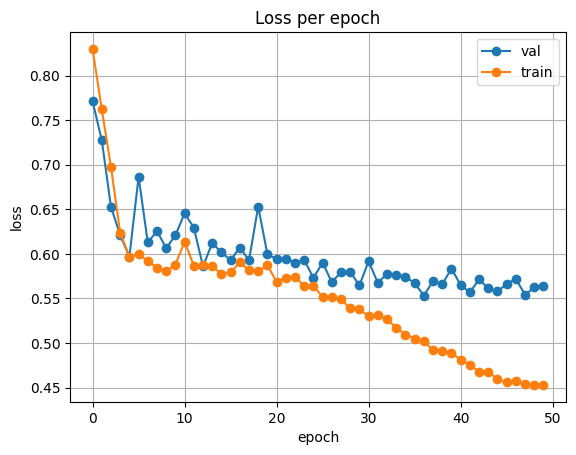

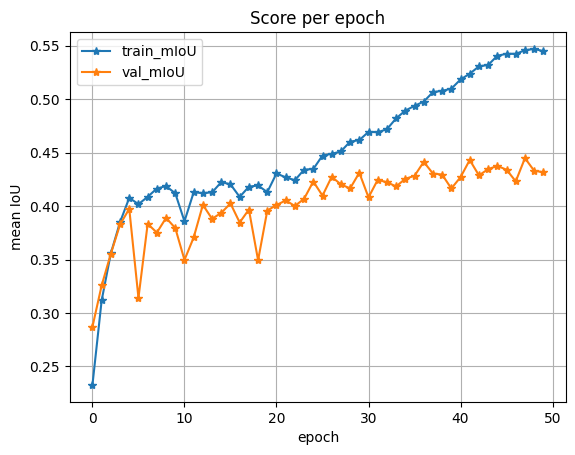

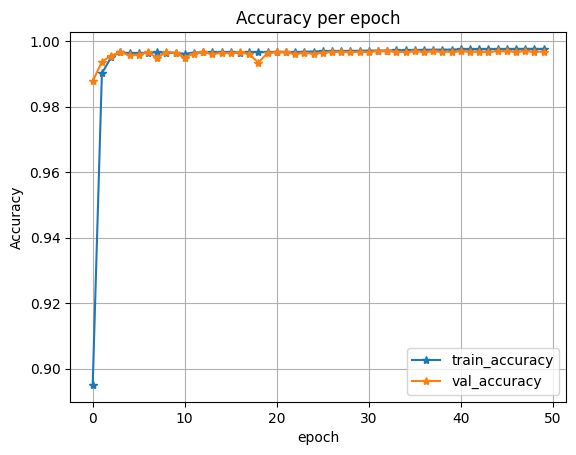

In [ ]:
plot_loss(history)
plot_score(history)
plot_acc(history)

#after Training

In [ ]:
#Testing Loader
class FilamentTestDataset(Dataset):

    def __init__(self, img_path, mask_path, X, transform=None):
        self.img_path = img_path
        self.mask_path = mask_path
        self.X = X
        self.transform = transform

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        img = cv2.imread(self.img_path + self.X[idx] + '.jpeg', cv2.IMREAD_GRAYSCALE)
        # img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.mask_path + self.X[idx] + '.png')
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)

        # Convert the mask from RGB to 2D grayscale
        mask = rgb2mask(mask)

        if self.transform is not None:
            aug = self.transform(image=img, mask=mask)
            img = Image.fromarray(aug['image'])
            mask = aug['mask']

        if self.transform is None:
            img = Image.fromarray(img)

        # Convert the PIL image to a NumPy array to calculate mean and std
        img_array = np.array(img)
        # Calculate the mean and standard deviation for normalization
        img_mean = img_array.mean(axis=(0, 1)) / 255.0  # Normalize to [0, 1]
        img_std = img_array.std(axis=(0, 1)) / 255.0

        t = T.Compose([T.ToTensor(), T.Normalize(img_mean.tolist(), img_std.tolist())])
        img = t(img)
        mask = torch.from_numpy(mask).long()

        # Get the name of the image
        img_name = self.X[idx]
        return img, mask, img_name


# t_test = A.Resize(768, 1152, interpolation=cv2.INTER_NEAREST)
t_test = None
test_set = FilamentTestDataset(IMAGE_PATH, MASK_PATH, X_test, transform=t_test)

In [ ]:
def predict_image_mask_miou(model, image, mask, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    model.eval()
    # Check if image is already a tensor, if not, convert it to one
    if not isinstance(image, torch.Tensor):
        t = T.Compose([T.ToTensor()])
        image = t(image)
    model.to(device); image=image.to(device)
    mask = mask.to(device)
    with torch.no_grad():

        image = image.unsqueeze(0)
        mask = mask.unsqueeze(0)

        output = model(image)
        score = mIoU(output, mask)
        masked = torch.argmax(output, dim=1)
        masked = masked.cpu().squeeze(0)
    return masked, score

In [ ]:
def predict_image_mask_pixel(model, image, mask, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    model.eval()
    # Check if image is already a tensor, if not, convert it to one
    if not isinstance(image, torch.Tensor):
        t = T.Compose([T.ToTensor()])
        image = t(image)
    model.to(device); image=image.to(device)
    mask = mask.to(device)
    with torch.no_grad():

        image = image.unsqueeze(0)
        mask = mask.unsqueeze(0)

        output = model(image)
        acc = pixel_accuracy(output, mask)
        masked = torch.argmax(output, dim=1)
        masked = masked.cpu().squeeze(0)
    return masked, acc

In [ ]:
model = torch.load('Jaccard_Unet-Mobilenet_50_epochs.pt')

In [ ]:
image, mask, image_name = test_set[3]

In [ ]:
pred_mask, score = predict_image_mask_miou(model, image, mask)

In [ ]:
def miou_score(model, test_set):
    score_iou = []
    for i in tqdm(range(len(test_set))):
        img, mask, image_name = test_set[i]
        pred_mask, score = predict_image_mask_miou(model, img, mask)
        score_iou.append(score)
    return score_iou

In [ ]:
mob_miou = miou_score(model, test_set)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [01:51<00:00,  1.20it/s]


In [ ]:
def pixel_acc(model, test_set):
    accuracy = []
    for i in tqdm(range(len(test_set))):
        img, mask, image_name = test_set[i]
        pred_mask, acc = predict_image_mask_pixel(model, img, mask)
        accuracy.append(acc)
    return accuracy

In [ ]:
mob_acc = pixel_acc(model, test_set)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [01:50<00:00,  1.21it/s]


In [ ]:
LTC = {
    0: [0, 0, 0],   #BACKGROUND
    1: [255, 0, 0],   #Left
    2: [0, 255, 0],  #right
    3: [0, 0, 255]    #Unidentifiable
}

def mask2rgb(mask):
    if isinstance(mask, torch.Tensor):
        mask = mask.cpu().detach().numpy()  # Convert PyTorch tensor to NumPy array

    h, w = mask.shape
    rgb = np.zeros((h, w, 3), dtype=np.uint8)

    for label, color in LTC.items():
        label_pixels = mask == label
        rgb[label_pixels] = color

    return rgb

In [ ]:
from PIL import Image
import numpy as np

def save_tensor_as_image(tensor, filename):
    # Convert the tensor to a NumPy array (assuming the values are in the range [0, 255])
    numpy_array = tensor.astype(np.uint8)

    # Create a Pillow Image from the NumPy array
    image = Image.fromarray(numpy_array)

    # Save the image in PNG format without compression
    image.save(filename)

In [ ]:
import shutil

def copy_image(image_name, dest_path, source_path):
  # Define the source file path
  source_file = f'{source_path}/{image_name}.jpeg'

  # Define the destination folder path
  destination_folder = f'{dest_path}/'

  # Copy the file from the source folder to the destination folder
  shutil.copy(source_file, destination_folder)

In [ ]:
for x in range(0, 10):
  image, mask, image_name = test_set[x]
  pred_mask, score = predict_image_mask_miou(model, image, mask)
  pred_mask = mask2rgb(pred_mask)
  mask = mask2rgb(mask)
  output_directory = f'test_results/test_{x}/'

  # Create the directory if it doesn't exist
  os.makedirs(output_directory, exist_ok=True)
  copy_image(image_name, f'{output_directory}', 'Data/Data/images/')
  # save_tensor_as_image(image, f'{output_directory}/{image_name}.jpeg')
  save_tensor_as_image(pred_mask, f'{output_directory}/{image_name}_pred_mask.png')
  save_tensor_as_image(mask, f'{output_directory}/{image_name}_mask.png')

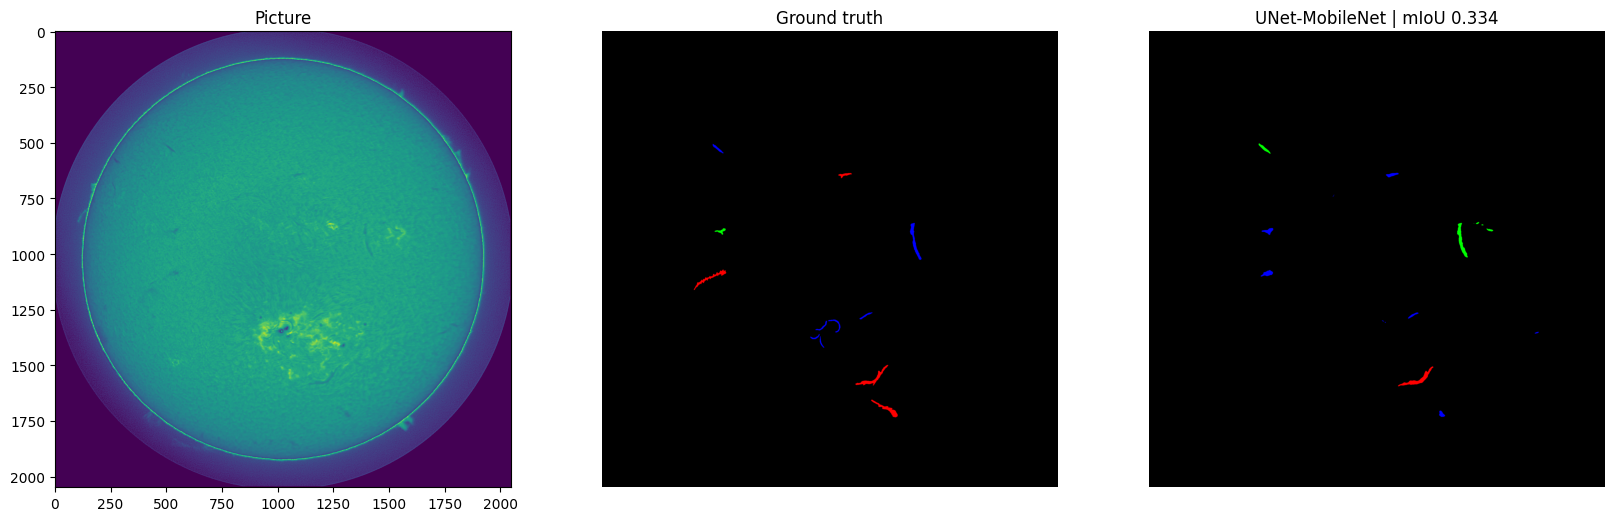

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,10))
image, mask, image_name = test_set[2]
pred_mask, score = predict_image_mask_miou(model, image, mask)
pred_mask = mask2rgb(pred_mask)
mask = mask2rgb(mask)
ax1.imshow(image[0])
ax1.set_title('Picture');

ax2.imshow(mask)
ax2.set_title('Ground truth')
ax2.set_axis_off()

ax3.imshow(pred_mask)
ax3.set_title('UNet-MobileNet | mIoU {:.3f}'.format(score))
ax3.set_axis_off()

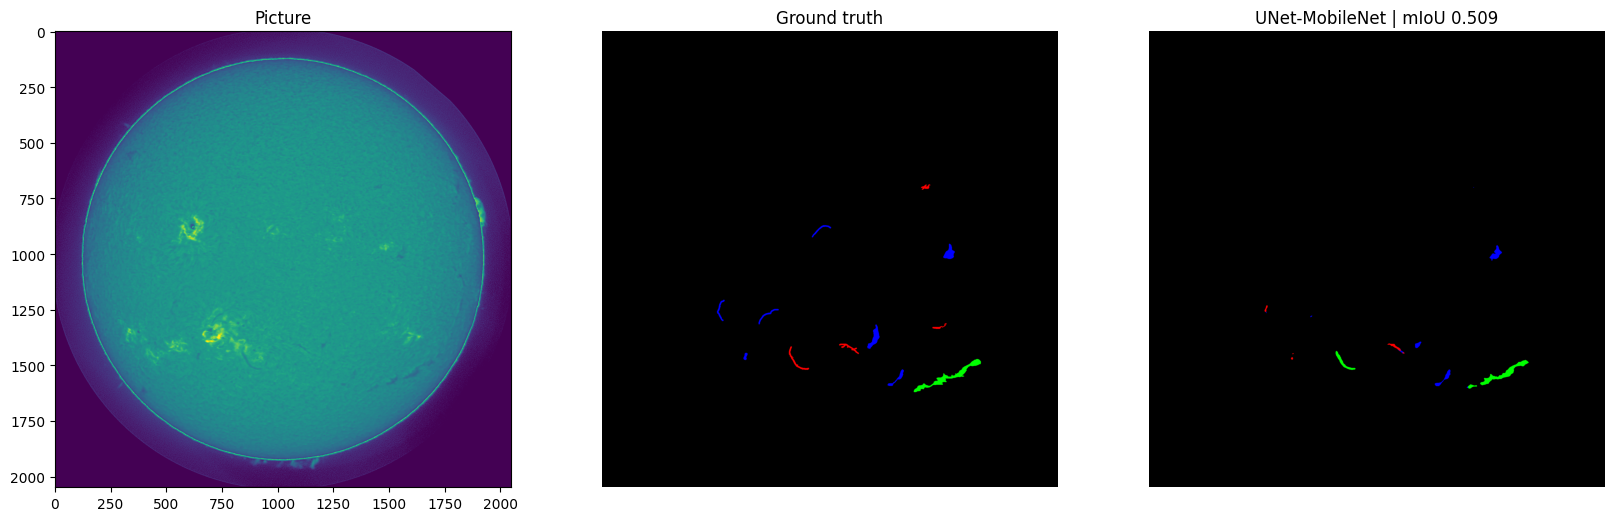

In [ ]:
image2, mask2, image_name = test_set[4]
pred_mask2, score2 = predict_image_mask_miou(model, image2, mask2)
pred_mask2 = mask2rgb(pred_mask2)
mask2 = mask2rgb(mask2)

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,10))
ax1.imshow(image2[0])
ax1.set_title('Picture');

ax2.imshow(mask2)
ax2.set_title('Ground truth')
ax2.set_axis_off()

ax3.imshow(pred_mask2)
ax3.set_title('UNet-MobileNet | mIoU {:.3f}'.format(score2))
ax3.set_axis_off()

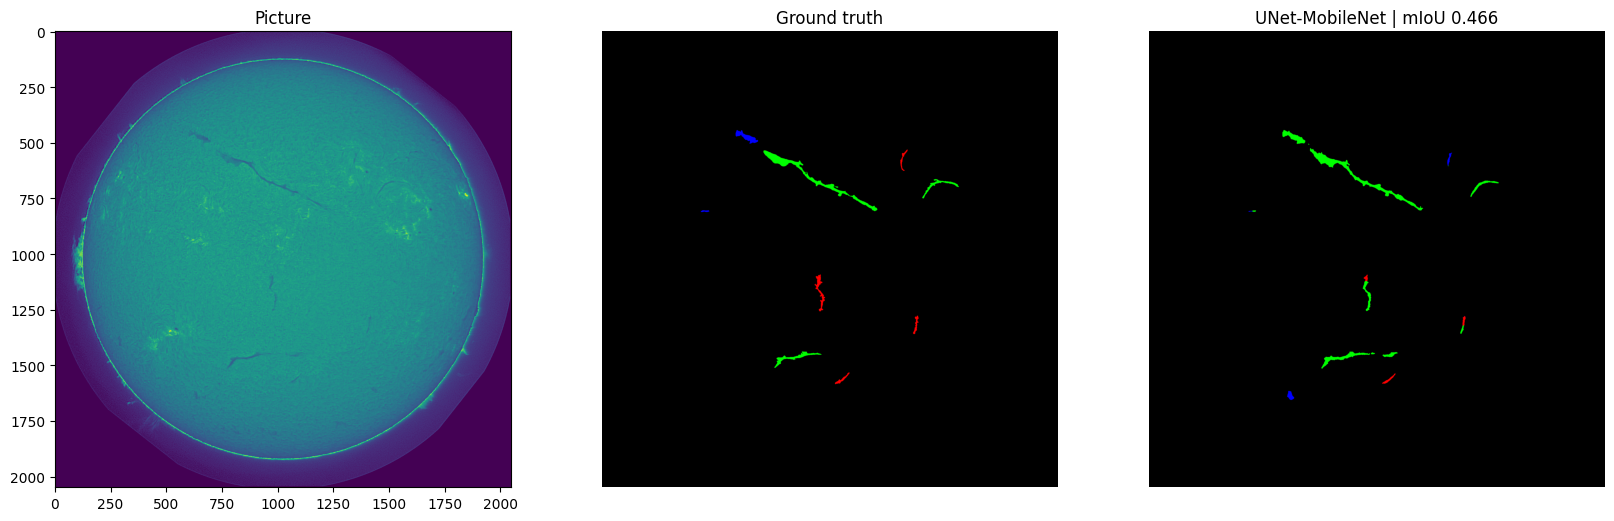

In [ ]:
# from utils import mask2rgb

image3, mask3, image_name = test_set[6]
pred_mask3, score3 = predict_image_mask_miou(model, image3, mask3)
pred_mask3 = mask2rgb(pred_mask3)
mask3 = mask2rgb(mask3)

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,10))
ax1.imshow(image3[0])
ax1.set_title('Picture');

ax2.imshow(mask3)
ax2.set_title('Ground truth')
ax2.set_axis_off()

ax3.imshow(pred_mask3)
ax3.set_title('UNet-MobileNet | mIoU {:.3f}'.format(score3))
ax3.set_axis_off()

In [ ]:
print('Test Set mIoU', np.mean(mob_miou))

Test Set mIoU 0.4978844270213954


In [ ]:
print('Test Set Pixel Accuracy', np.mean(mob_acc))

Test Set Pixel Accuracy 0.9969080668776783
